In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('./data/transactions.csv')

# 1. Handle missing values
# Drop rows where both quantity and price are NaN
df = df.dropna(subset=['quantity', 'price'], how='all')

# Fill missing values
df['quantity'].fillna(df['quantity'].median(), inplace=True)
df['price'].fillna(df['price'].mean(), inplace=True)

# 2. Remove duplicate transactions
df.drop_duplicates(inplace=True)

# 3. Create a 'day_of_week' column
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.day_name()

# Output after cleaning
df.head()


/var/folders/53/zkscskj93rxfxqs20ys84nh40000gn/T/ipykernel_27981/3317954429.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['quantity'].fillna(df['quantity'].median(), inplace=True)
/var/folders/53/zkscskj93rxfxqs20ys84nh40000gn/T/ipykernel_27981/3317954429.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

,transaction_id,customer_id,date,product_id,store_id,quantity,price,total_amount,day_of_week
0,1,45,2023-12-23,4,1,7.0,29.24,278.88,Saturday
1,2,48,2023-12-05,32,1,4.0,24.38,195.93,Tuesday
2,3,65,2023-03-29,30,1,6.0,41.67,53.79,Wednesday
3,4,68,2023-01-03,17,1,9.0,13.86,21.26,Tuesday
4,5,68,2023-09-22,4,5,3.0,17.23,155.50,Friday


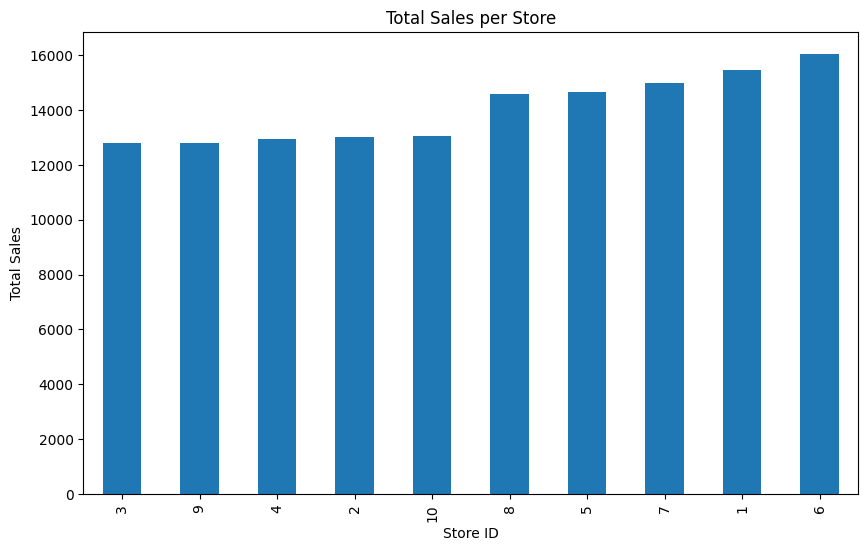

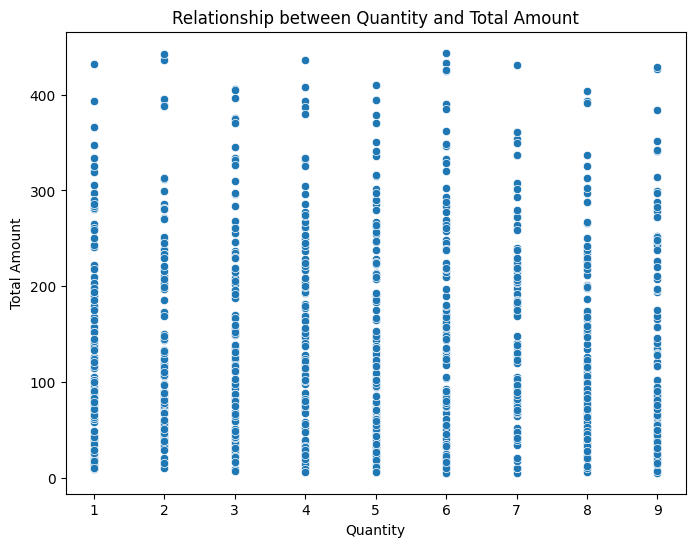

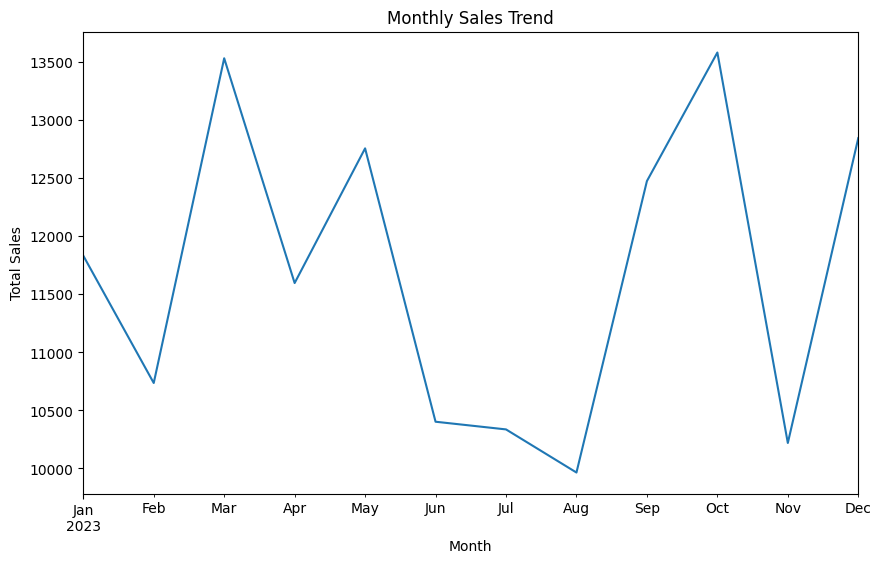

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of total sales per store
store_sales = df.groupby('store_id')['total_amount'].sum().sort_values()
plt.figure(figsize=(10, 6))
store_sales.plot(kind='bar')
plt.title('Total Sales per Store')
plt.xlabel('Store ID')
plt.ylabel('Total Sales')
plt.show()

# 2. Relationship between quantity and total_amount
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='quantity', y='total_amount')
plt.title('Relationship between Quantity and Total Amount')
plt.xlabel('Quantity')
plt.ylabel('Total Amount')
plt.show()

# 3. Monthly sales trends
df['month'] = df['date'].dt.to_period('M')
monthly_sales = df.groupby('month')['total_amount'].sum()
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='line')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()


In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# RFM analysis
df['recency'] = (df['date'].max() - df.groupby('customer_id')['date'].transform('max')).dt.days
df['frequency'] = df.groupby('customer_id')['transaction_id'].transform('count')
df['monetary'] = df.groupby('customer_id')['total_amount'].transform('sum')

rfm_df = df[['customer_id', 'recency', 'frequency', 'monetary']].drop_duplicates()

# Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['recency', 'frequency', 'monetary']])

# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['segment'] = kmeans.fit_predict(rfm_scaled)

# Interpretation
rfm_df.groupby('segment').mean()


,customer_id,recency,frequency,monetary
segment,,,,
0,50.823529,79.117647,9.117647,1325.862353
1,49.657895,25.578947,7.973684,1009.114211
2,51.500000,17.175000,12.625000,1848.054750
3,47.800000,144.200000,7.400000,1092.000000


In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# RFM analysis
df['recency'] = (df['date'].max() - df.groupby('customer_id')['date'].transform('max')).dt.days
df['frequency'] = df.groupby('customer_id')['transaction_id'].transform('count')
df['monetary'] = df.groupby('customer_id')['total_amount'].transform('sum')

rfm_df = df[['customer_id', 'recency', 'frequency', 'monetary']].drop_duplicates()

# Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['recency', 'frequency', 'monetary']])

# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['segment'] = kmeans.fit_predict(rfm_scaled)

# Interpretation
rfm_df.groupby('segment').mean()


,customer_id,recency,frequency,monetary
segment,,,,
0,50.823529,79.117647,9.117647,1325.862353
1,49.657895,25.578947,7.973684,1009.114211
2,51.500000,17.175000,12.625000,1848.054750
3,47.800000,144.200000,7.400000,1092.000000


In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare features and target variable
df['month'] = df['date'].dt.month
X = df[['store_id', 'month', 'quantity', 'price']]
y = df['total_amount']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_cv_score = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

# Gradient Boosting Model
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
gb_cv_score = cross_val_score(gb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

# Choose the best model and evaluate on the test set
model = gb if abs(gb_cv_score) < abs(lr_cv_score) else lr
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

rmse, model


(104.70795989847146, LinearRegression())